## Chapter 11: Training Deep Neural Nets

## Vanishing/Exploding Gradients Problems

* Gradients often get smaller and smaller as the algorithm progresses down to the lower layers. 
* As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged.
* In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem. It is mostly encountered in recurrent neural networks.

### Xavier and He Initialization

* The variance of the outputs of each layer should be equal to the variance of its inputs.
* The gradients should have equal variance before and after flowing through a layer in the reverse direction.

Glorot and Bengio (2010) proposed the following random initialization distributions for the edges weights.

$N(0,\sigma)$ with $\sigma = \sqrt{\frac{2}{n_{inputs} + n_{outputs}}}$ or $U(-r,r)$ with $r = \sqrt{\frac{6}{n_{inputs} + n_{outputs}}}$

* This strategy works well with Logistic activations. For the hyperbolic tangent, a constant 4 is multiplied in $\sigma$ and $r$, while ReLU activations work better with a $\sqrt{2}$ constant.
* The He initialization is quite similar but removes the $n_{outputs}$ term.

### ReLU variants

* During training, some neurons die, they stop outputting anything other than 0.
* When this happen, the neuron is unlikely to come back to life since the gradient of the ReLU function is 0 when its input is negative.

To solve this problem, one can use a variant of the ReLU function, such as the leaky ReLU with $\alpha \in (0,1)$ (tipically 0.01 or 0.2):

$LeakyReLU_\alpha(z) = max(\alpha z, z)$

Another popular variant is the Exponential LU, which is slower to compute but is smooth in all the domain and often compensates with convergence speed:

$ELU(z) = \begin{cases} \alpha (e^{z} - 1) & \text {if } z < 0 \\ z & \text{if } z \geq 0 \end{cases}$

#### Note
* In TF, to specify ELU activation: hidden1 = fully_connected(X, n_hidden1, activation_fn=tf.nn.elu)

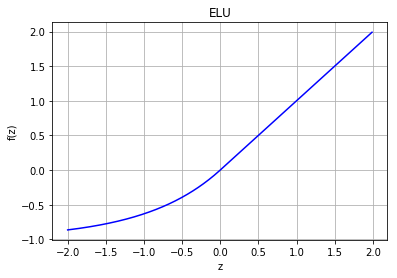

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
alpha = 1
z = np.arange(-2.0, 2.0, 0.01)
f = (z < 0) * alpha * (np.exp(z) - 1) + (z >= 0) * z
fig, ax = plt.subplots()
ax.plot(z, f, 'b-')
ax.set(xlabel='z', ylabel='f(z)', title='ELU')
ax.grid()
plt.show()

## Batch Normalization

* Vanishing/exploding gradients problems can come back during training.
* Sergey Ioffe and Christian Szegedy (2015) proposed a technique called Batch Normalization (BN).
* The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer.

Concretely, before applying the activation function (if any) the following operation is performed in each layer:

$\hat x^{(i)} = S * (\frac{x^{(i)} - x_{batch}}{\sigma_{batch}}) + B$ (where $x_{batch},\sigma_{batch}$ are the empirical mean/stdev of the current batch and $S,B$ are the scale and bias to be learned).

#### Notes

* It improves convergence so much that Sigmoid and Tanh functions are possible to use when paired with BN. 
* Apart from speed, it reduces overfitting and improves accuracy.
* However, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer.

In [2]:
import tensorflow as tf

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [67]:
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.layers import batch_norm

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

bn_params = {
    'is_training': is_training, # use mini-batch mean/std (training) or running averages (testing)
    'decay': 0.99, # exponential decay to compute the running averages
    'updates_collections': None, # update the running averages right before batch normalization in training
    'scale': True, # if activation is other than None or ReLU,
    'center': True, 
    'reuse': False,
}

with tf.contrib.framework.arg_scope([fully_connected], normalizer_fn=batch_norm, normalizer_params=bn_params):
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
    hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
    logits = fully_connected(hidden2, n_outputs, scope="outputs", activation_fn=None)

## Gradient Clipping
* A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold.

In [69]:
threshold = 1.0
learning_rate = 0.2

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_and_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        training_op = optimizer.minimize(loss)
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## Full example

In [70]:
from aux import create_mini_batches

X_train = X_train.reshape(-1, n_inputs)
y_train = y_train.reshape(-1)

X_test = X_test.reshape(-1, n_inputs)
y_test = y_test.reshape(-1)

n_epochs = 10
batch_size = 100
n_batches = X_train.shape[0] // batch_size

init = tf.global_variables_initializer()
with tf.Session() as sess: 
    sess.run(init)
    for epoch in range(n_epochs):
        for X_batch, y_batch in create_mini_batches(X_train, y_train, n_batches, n_inputs, 1): 
            sess.run(training_op, feed_dict={is_training: True, X: X_batch, y: y_batch})
        accuracy_score = accuracy.eval(feed_dict={is_training: True, X: X_train, y: y_train})
        print("Epoch", epoch, "Accuracy", accuracy_score)
        tf.train.Saver(var_list=tf.global_variables()).save(sess, "./c11_bn_final.ckpt")

Epoch 0 Accuracy 0.9572167
Epoch 1 Accuracy 0.9741667
Epoch 2 Accuracy 0.98291665
Epoch 3 Accuracy 0.98908335
Epoch 4 Accuracy 0.9920833
Epoch 5 Accuracy 0.99516666
Epoch 6 Accuracy 0.99663335
Epoch 7 Accuracy 0.99801666
Epoch 8 Accuracy 0.99883336
Epoch 9 Accuracy 0.99945


In [115]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, "./c11_bn_final.ckpt")
    y_pred = sess.run([tf.math.argmax(logits, axis=1)], feed_dict={X: X_test, is_training: True})
    print("Target    ", y_test[:30])
    print("Prediction", y_pred[0][:30])
    print ("Accuracy", np.sum(y_pred == y_test) / len(y_pred[0]))

INFO:tensorflow:Restoring parameters from ./c11_bn_final.ckpt
Target     [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
Prediction [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
Accuracy 0.9791


## Transfer learning

In [116]:
def create_trasnfer_nn(original_w, original_b):
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X") 
    hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
    hidden2 = fully_connected(X, n_hidden2, scope="hidden2")
    logits = fully_connected(X, n_outputs, scope="logits")

    # Get a handle on the variables created by fully_connected()
    with tf.variable_scope("", default_name="", reuse=True): # root scope
        hidden1_weights = tf.get_variable("hidden1/weights")
        hidden1_biases = tf.get_variable("hidden1/biases")
        
    # Create nodes to assign arbitrary values to the weights and biases
    original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
    original_biases = tf.placeholder(tf.float32, shape=(n_hidden1))
    assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
    assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess: 
        sess.run(init)
        sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w}) 
        sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
#         train()

## Optimizers

### Momentum optimizer

* Instead of following the gradient through a constant learning rate, use the gradient as acceleration.
* Algorithm: ($\alpha > 0$ learning rate, $\beta \in [0,1]$ momentum friction, $m_{init}=0$)
    
    $m \leftarrow \beta m + \alpha \nabla_\theta cost(\theta)$
    
    $\theta^{new} \leftarrow \theta - m$
    
* In TF: 

    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)

### Nesterov Accelerated Gradient

* Almost always faster than the Momentum optimizer as-is.
* Algorithm:
    
    $m \leftarrow \beta m + \alpha \nabla_\theta cost(\theta + \beta m)$
    
    $\theta^{new} \leftarrow \theta - m$
    
* In TF:

    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9, use_nesterov=True)

### Adam

* Uses intuitions of Momentum and RMSProp.
* It is almost always the best option so far in the literature.
* Algorithm:
    
    $m \leftarrow \beta_1 m + (1-\beta_1) \nabla_\theta cost(\theta + \beta m)$
    
    $s \leftarrow \beta_2 s + (1-\beta_2) \nabla_\theta cost(\theta + \beta m)^2$ (element wise)
    
    $m \leftarrow \frac{m}{1-\beta_1^T}$ (kickstarting fast)
    
    $s \leftarrow \frac{s}{1-\beta_2^T}$ (kickstarting fast)
    
    $\theta^{new} \leftarrow \theta - \alpha m / \sqrt{s+\epsilon}$ (element wise)
    
    
* Hyperparameters: $\alpha,\beta_1,\beta_2, \epsilon$ control learning rate, momentum decay, scaling decay and smoothing term. 


* Tipically TFs standard values work well ($\beta_1=0.9,\beta_2=0.999,\epsilon=10^{-8}$).


* In TF:

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


## Regularization

### Early stopping

* As the name suggests, just save multiple partially trained instances of the parameters.
* Then select the one that generalizes the best.

### $l_1$ and $l_2$

In [118]:
def create_reg_layers(X, y, n_hidden1, n_hidden2, n_outputs, scale=0.01):
    with arg_scope([fully_connected],weights_regularizer=tf.contrib.layers.l1_regularizer(scale=scale)):
        # Create layers
        hidden1 = fully_connected(X, n_hidden1, scope="hidden1")
        hidden2 = fully_connected(hidden1, n_hidden2, scope="hidden2")
        logits = fully_connected(hidden2, n_outputs, activation_fn=None,scope="out")
        # Define loss
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([base_loss] + reg_losses, name="loss")

### Dropout

* At every training step, every neuron (including input neurons but excluding output neurons) has a probability p of being temporarily “dropped out”.
* It will be entirely ignored during this training step, but it may be active during the next step.

In [119]:
from tensorflow.contrib.layers import dropout 

def create_drop_layers(X, y, n_hidden1, n_hidden2, n_outputs, p=0.5):
    with arg_scope([fully_connected],weights_regularizer=tf.contrib.layers.l1_regularizer(scale=scale)):
        is_training = tf.placeholder(tf.bool, shape=(), name='is_training')
        # Create layers
        X_drop = dropout(X, p, is_training=is_training)
        hidden1 = fully_connected(X_drop, n_hidden1, scope="hidden1")
        hidden1_drop = dropout(hidden1, keep_prob, is_training=is_training)
        hidden2 = fully_connected(hidden1_drop, n_hidden2, scope="hidden2")
        hidden2_drop = dropout(hidden2, keep_prob, is_training=is_training)
        logits = fully_connected(hidden2_drop, n_outputs, activation_fn=None,scope="outputs")
        # Define loss
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([base_loss] + reg_losses, name="loss")

### Data Augmentation

* Generating new training instances from existing ones, artificially boosting the size of the training set.
* For example, if your model is meant to classify pictures of mushrooms, you can slightly shift, rotate, and resize every picture in the training set by various amounts and add the resulting pictures to the training set.

## Default DNN configuration

* Initialization: He
* Activation function: ELU
* Normalization: Batch normalization
* Regularization: Dropout
* Optimizer: Adam
* Learning rate schedule: None

#### Notes
* If you can’t find a good learning rate (convergence was too slow, so you increased the training rate, and now convergence is fast but the network’s accuracy is sub‐ optimal), then you can try adding a learning schedule such as exponential decay.
* If your training set is a bit too small, you can implement data augmentation.
* If you need a sparse model, you can add some l1 regularization to the mix (and optionally zero out the tiny weights after training). If you need an even sparser model, you can try using FTRL instead of Adam optimization, along with l1 reg‐ ularization.
* If you need a lightning-fast model at runtime, you may want to drop Batch Nor‐ malization, and possibly replace the ELU activation function with the leaky ReLU. Having a sparse model will also help.
